In [106]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
from public_tests import *
%matplotlib inline

My Problem Statement

Using Neural Style Transfer (NST), I aim to merge two images, namely: a <strong>"content" image (C)</strong> and a <strong>"style" image (S)</strong>, to create a <strong>"generated" image (G)</strong>. The generated image G combines the "content" of the image C with the "style" of image S. I have used VGG-19 network to build this application, i.e., I've made use of transfer learning here.

In [107]:
tf.random.set_seed(272)
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='pretrained-model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False
pp.pprint(vgg)

The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.


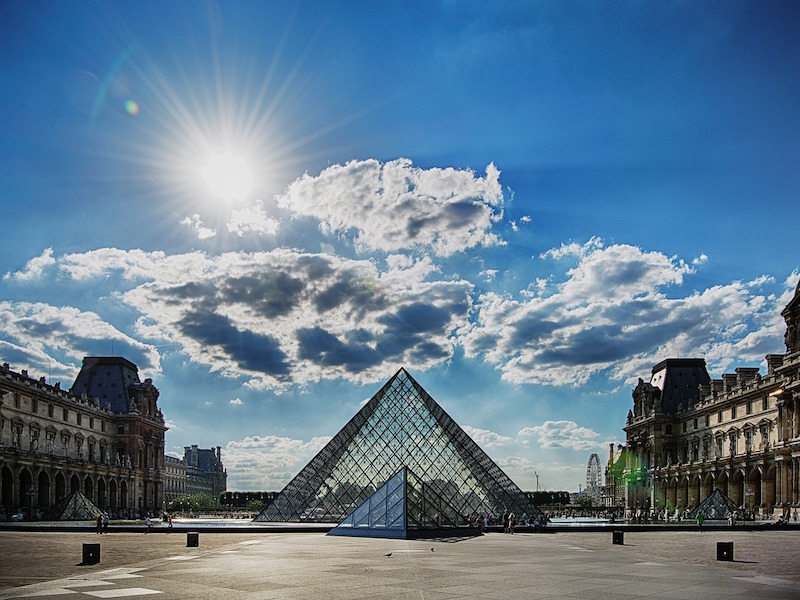

In [108]:
content_image = Image.open("images/louvre.jpg")
print("The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.")
content_image

In [109]:
def compute_content_cost(content_output, generated_output):
    """
    Computing the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- the content cost
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_C_unrolled = tf.reshape(a_C, shape = [_, -1, n_C])
    a_G_unrolled = tf.reshape(a_G, shape = [_, -1, n_C])
    # computing the cost with tensorflow
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))/(4*n_H*n_W*n_C)
    
    return J_content

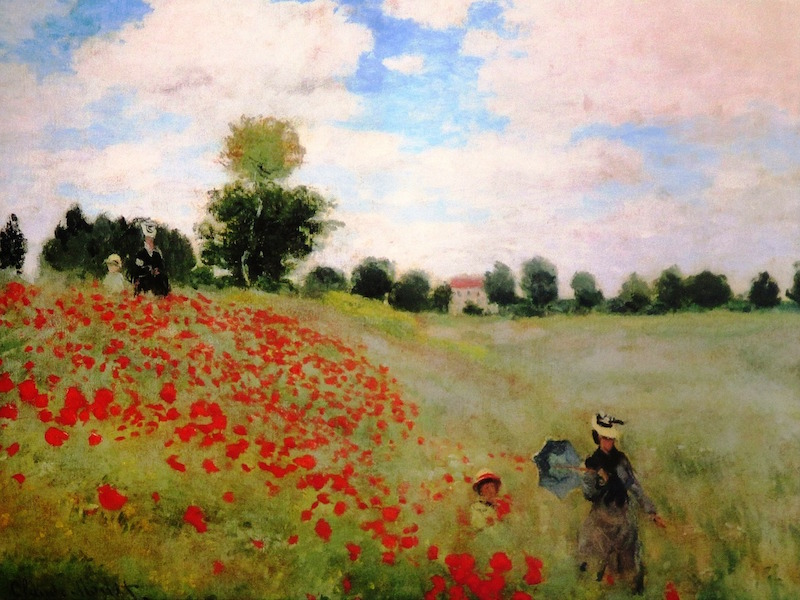

In [111]:
example = Image.open("images/monet_800600.jpg")
example

In [112]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """  
    GA = tf.linalg.matmul(A, tf.transpose(A))

    return GA

In [114]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer
    """
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S, shape=[-1,n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss
    J_style_layer = (1 / (4 * n_C **2 * (n_H * n_W) **2)) * tf.reduce_sum(tf.square(tf.subtract(GS, GG)))
    
    
    return J_style_layer

In [116]:
for layer in vgg.layers:
    print(layer.name)

input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [117]:
vgg.get_layer('block5_conv4').output

<KerasTensor: shape=(None, 25, 25, 512) dtype=float32 (created by layer 'block5_conv4')>

In [118]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

In [119]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    style_image_output -- the tensorflow model
    generated_image_output --
    STYLE_LAYERS
    
    Returns: 
    J_style
    """
    J_style = 0

    a_S = style_image_output[:-1]

    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        J_style += weight[1] * J_style_layer

    return J_style

In [120]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    """
    J = alpha*J_content + beta*J_style

    return J

(400, 400, 3)
(1, 400, 400, 3)


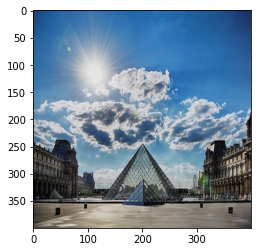

In [122]:
content_image = np.array(Image.open("images/louvre_small.jpg").resize((img_size, img_size)))
print(content_image.shape)
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

(400, 400, 3)
(1, 400, 400, 3)


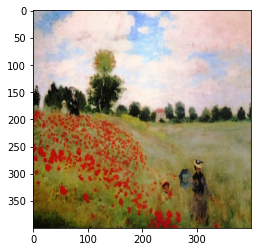

In [123]:
style_image =  np.array(Image.open("images/monet.jpg").resize((img_size, img_size)))
print(style_image.shape)
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

(1, 400, 400, 3)


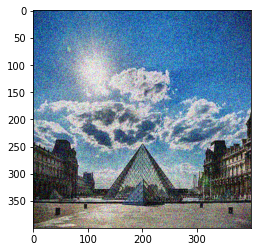

In [124]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

In [125]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [126]:
content_layer = [('block5_conv4', 1)]

all_layer_names = STYLE_LAYERS + content_layer
vgg_model_outputs = get_layer_outputs(vgg, all_layer_names)

In [127]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style encoder
print(len(content_target))
print(len(style_targets))

6
6


In [128]:
# Assign the content image to be the input of the VGG model.  
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

In [129]:
# Assign the input of the model to be the "style" image 
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [130]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [131]:

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        
        
        a_G = vgg_model_outputs(generated_image)
        
        # Compute the style cost
        J_style = compute_style_cost(a_S, a_G)

        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G)
        # Compute the total cost
        J = total_cost(J_content, J_style)  
        
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    return J

Epoch 0 


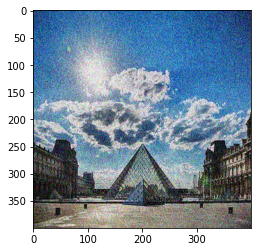

Epoch 250 


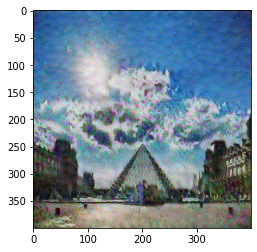

Epoch 500 


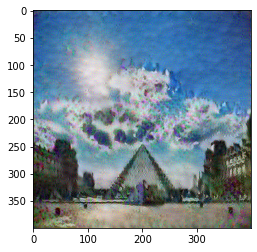

Epoch 750 


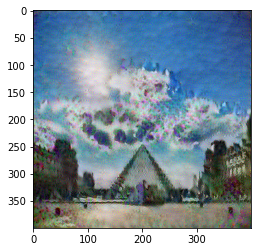

Epoch 1000 


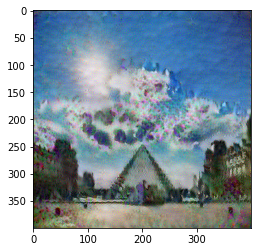

Epoch 1250 


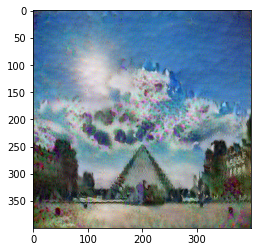

Epoch 1500 


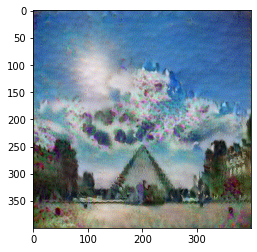

Epoch 1750 


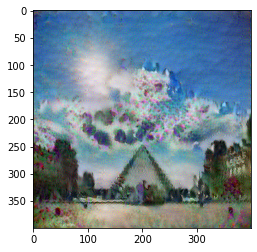

Epoch 2000 


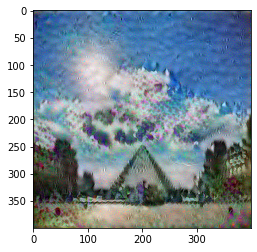

Epoch 2250 


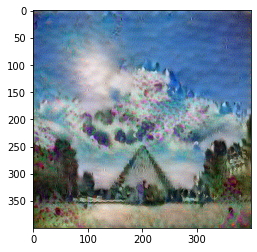

Epoch 2500 


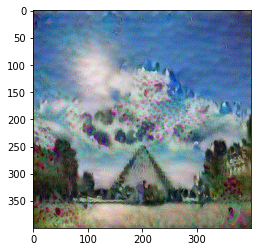

In [133]:
# Taking a look at how image is being converted
epochs = 2501
for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i} ")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"output/image_{i}.jpg")
        plt.show() 

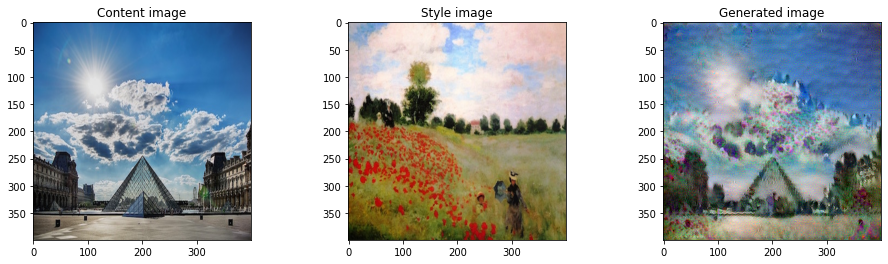

In [134]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()